# Transfer Learning: involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

## Get Data

In [1]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "food-101-mini"

if data_path.is_dir():
  print(f"{data_path} already exists")
else:
  print(f"Creating {data_path} and download food-101-mini datasets...")
  data_path.mkdir(parents=True, exist_ok=True)
  with open(data_path / "food-101-mini.zip", "wb") as f:
    request = requests.get("https://github.com/yongbinkim-chemist/deep_learning/raw/refs/heads/main/computer_vision/data/food-101-mini/food-101-mini.zip")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "food-101-mini.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(path=data_path)
  !rm -rf data/__MACOSX/
  !rm -f data/food-101-mini.zip

data already exists


## Import code

In [2]:
if Path("src").is_dir():
  from src import data_setup
else:
  !git clone https://github.com/yongbinkim-chemist/deep_learning.git
  !mv deep_learning/computer_vision/src .
  !rm -rf deep_learning/
  from src import data_setup

## Creating a transform for `torchvision.models`

In [3]:
import torchvision

In [4]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "Default" -> best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [5]:
image_transform = weights.transforms()
image_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

# Transform image into train and test dataloaders

In [6]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
SEED = 42

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(image_path=data_path,
                                                                               transform=image_transform,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS,
                                                                               seed=SEED)
class_names

['bibimbap', 'hamburger', 'sashimi']

In [7]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

## Setup pretrained model (EfficientNet_B0)

In [8]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights)
summary(model=model,
        input_size=(1, 3, 244, 244),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 16, 122,

## Freeze Features, Retrain, classfier

**Note** change output shape: 1000 -> 3

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,
               inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device)
)

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [14]:
summary(model=model,
        input_size=(1, 3, 244, 244),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 1

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-2)

In [16]:
from src import engine

In [17]:
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | Train loss: 0.8222 | Train acc: 0.6328 | Test loss: 0.3063 | Test acc: 0.8665
Epoch: 2 | Train loss: 0.4447 | Train acc: 0.7578 | Test loss: 0.3480 | Test acc: 0.7841
Epoch: 3 | Train loss: 0.6506 | Train acc: 0.7773 | Test loss: 0.2896 | Test acc: 0.9062
Epoch: 4 | Train loss: 0.5665 | Train acc: 0.7930 | Test loss: 0.6269 | Test acc: 0.7936
Epoch: 5 | Train loss: 0.2389 | Train acc: 0.9258 | Test loss: 0.3339 | Test acc: 0.9167


In [21]:
from src import predict

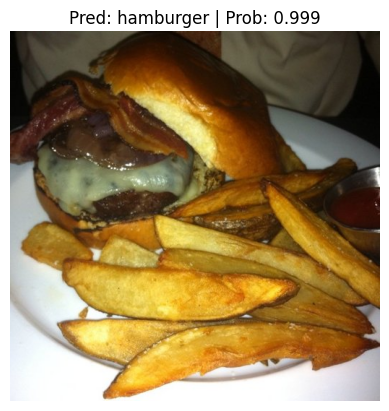

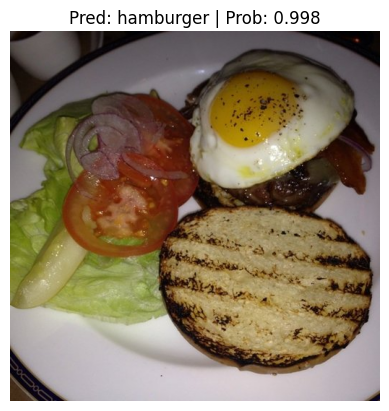

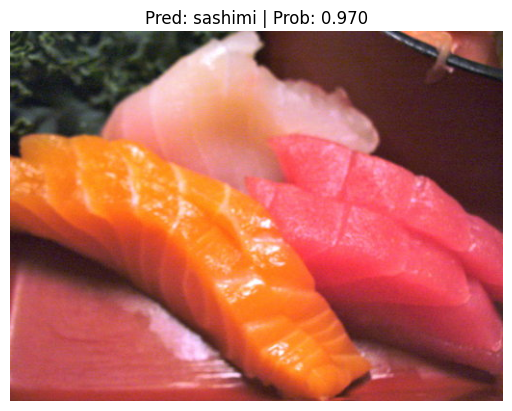

In [22]:
import random

image_list = list(data_path.glob("*/*.jpg"))
random_image_list = random.sample(image_list, k=3)

for img in random_image_list:
  predict.predict_and_plot(model=model,
                           class_names=class_names,
                           image_path=str(img),
                           image_size=(244, 244),
                           transform=image_transform,
                           device=device)